# Sentiment Analysis and prediction models on movie reviews

In [38]:
#Load the libraries
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
from textblob import Word
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
warnings.filterwarnings('ignore')


In [39]:
#importing the data
Letterbox_DS=pd.read_csv('DataSet.csv')
print(Letterbox_DS.shape)
Letterbox_DS.head(5)

(8714, 2)


,comment,result
0,bad thing horribl score idc anyon say score do...,Negative
1,lazi unorigin film class mental health ugh tod...,Negative
2,good thing great soundtrack jimmi durant frank...,Positive
3,also found surprisingli profound realli make t...,Positive
4,probabl best romant movi ive seen yetit beauti...,Positive


In [40]:
#Summary of the dataset
Letterbox_DS.describe()

,comment,result
count,8714,8714
unique,8652,2
top,good morn case dont see ya good afternoon good...,Positive
freq,7,4452


In [41]:
#result count
Letterbox_DS['result'].value_counts()

result
Positive    4452
Negative    4262
Name: count, dtype: int64

This tokenizer handles various character encodings and punctuation,
potentially improving the accuracy of the sentiment analysis.

In [42]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
    
#Apply function on comment column
Letterbox_DS['comment']=Letterbox_DS['comment'].apply(remove_special_characters)

 reduce words to their base or root form to improved accuracy and reduces vocabulary size

In [43]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
    
#Apply function on comment column
Letterbox_DS['comment']=Letterbox_DS['comment'].apply(simple_stemmer)

  Tokenize text using ToktokTokenizer for improved handling of characters and punctuation and Remove stopwords (common English words) to focus on sentiment-bearing terms.

In [44]:

#Tokenization of text
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]     
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on comment column
Letterbox_DS['comment']=Letterbox_DS['comment'].apply(remove_stopwords)

Select first 7000 comments from training data (normalized test & train data)
  Split data to test and train 

In [45]:
#normalized train comments
norm_train_comments=Letterbox_DS.comment[:7000]
#Normalized test comments
norm_test_comments=Letterbox_DS.comment[7000:]

 Convert unstructured text data into numerical format using vectorizer
  BoW: Counts the occurrences of each word in a document, this helps to consider all combinations of words and get higher accuracy.

In [46]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train comments
cv_train_comments=cv.fit_transform(norm_train_comments)
#transformed test comments
cv_test_comments=cv.transform(norm_test_comments)

print('BOW_cv_train:',cv_train_comments.shape)
print('BOW_cv_test:',cv_test_comments.shape)


BOW_cv_train: (7000, 1156001)
BOW_cv_test: (1714, 1156001)


TF-IDF vectorizer assigns more weight to words that are frequent within a document but rare across the entire collection. This can be beneficial for tasks like topic modeling or document classification.

In [48]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train comments
tv_train_comments=tv.fit_transform(norm_train_comments)
#transformed test comments
tv_test_comments=tv.transform(norm_test_comments)
print('Tfidf_train:',tv_train_comments.shape)
print('Tfidf_test:',tv_test_comments.shape)

Tfidf_train: (7000, 1156001)
Tfidf_test: (1714, 1156001)


Label binarization is  used for categorical data

In [74]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed result data
result_data=lb.fit_transform(Letterbox_DS['result'])
print(result_data.shape)

(8714, 1)


In [50]:
#Spliting the result data
train_results=result_data[:7000]
test_results=result_data[7000:]
print(train_results)
print(test_results)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


Fitting Logistic Regression 

In [75]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=100,C=1,random_state=22)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_comments,train_results)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_comments,train_results)
print(lr_tfidf)

LogisticRegression(C=1, random_state=22)
LogisticRegression(C=1, random_state=22)


In [52]:

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_comments)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_comments)
print(lr_tfidf_predict)

[0 0 1 ... 0 0 1]
[0 0 1 ... 0 1 1]


IN the comparison between the created model by BOW and TF-IDF we can see TF-IDF has better performance.

In [53]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_results,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_results,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7584597432905484
lr_tfidf_score : 0.8628938156359394


Exploring other evaluation metrics like precision, recall, or F1-score to get a more comprehensive understanding of models' performance.

In [54]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_results,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_results,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.70      0.95      0.80       890
    Negative       0.91      0.55      0.69       824

    accuracy                           0.76      1714
   macro avg       0.80      0.75      0.75      1714
weighted avg       0.80      0.76      0.75      1714

              precision    recall  f1-score   support

    Positive       0.85      0.89      0.87       890
    Negative       0.88      0.83      0.85       824

    accuracy                           0.86      1714
   macro avg       0.86      0.86      0.86      1714
weighted avg       0.86      0.86      0.86      1714



Confusion matrix for LR 

In [55]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_results,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_results,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[454 370]
 [ 44 846]]
[[686 138]
 [ 97 793]]


Modelling with SVM

In [56]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_comments,train_results)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_comments,train_results)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [57]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_comments)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_comments)
print(svm_tfidf_predict)

[0 0 1 ... 0 1 1]
[1 0 1 ... 0 1 1]


In [58]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_results,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_results,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8593932322053676
svm_tfidf_score : 0.882730455075846


In [59]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_results,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_results,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.84      0.90      0.87       890
    Negative       0.89      0.81      0.85       824

    accuracy                           0.86      1714
   macro avg       0.86      0.86      0.86      1714
weighted avg       0.86      0.86      0.86      1714

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.89       890
    Negative       0.87      0.89      0.88       824

    accuracy                           0.88      1714
   macro avg       0.88      0.88      0.88      1714
weighted avg       0.88      0.88      0.88      1714



In [60]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_results,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_results,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[670 154]
 [ 87 803]]
[[730  94]
 [107 783]]


Training with Naive Bayes Algorithm

In [61]:
#training the model
mnb=MultinomialNB()
#fitting the Naive Bayes for bag of words
mnb_bow=mnb.fit(cv_train_comments,train_results)
print(mnb_bow)
#fitting the Naive Bayes for tfidf features
mnb_tfidf=mnb.fit(tv_train_comments,train_results)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


NB performance with unseen Data

In [62]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_comments)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_comments)
print(mnb_tfidf_predict)

[0 0 1 ... 0 1 1]
[1 0 1 ... 0 1 1]


In [63]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_results,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_results,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8722287047841307
mnb_tfidf_score : 0.882147024504084


In [64]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_results,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_results,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.86      0.90      0.88       890
    Negative       0.88      0.84      0.86       824

    accuracy                           0.87      1714
   macro avg       0.87      0.87      0.87      1714
weighted avg       0.87      0.87      0.87      1714

              precision    recall  f1-score   support

    Positive       0.90      0.87      0.88       890
    Negative       0.87      0.89      0.88       824

    accuracy                           0.88      1714
   macro avg       0.88      0.88      0.88      1714
weighted avg       0.88      0.88      0.88      1714



In [65]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_results,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_results,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[696 128]
 [ 91 799]]
[[737  87]
 [115 775]]


Which words in comments express Negative or Positive?

<function matplotlib.pyplot.show(close=None, block=None)>

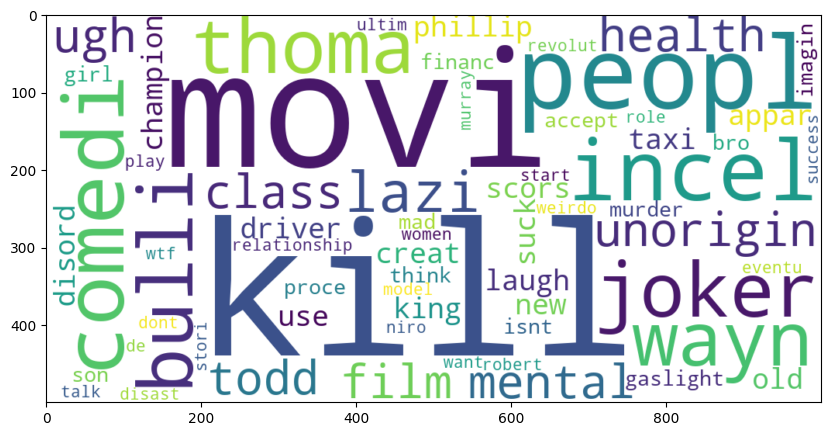

In [76]:
#word cloud for positive comment words
plt.figure(figsize=(10,10))
positive_text=norm_train_comments[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=3,background_color="white")
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

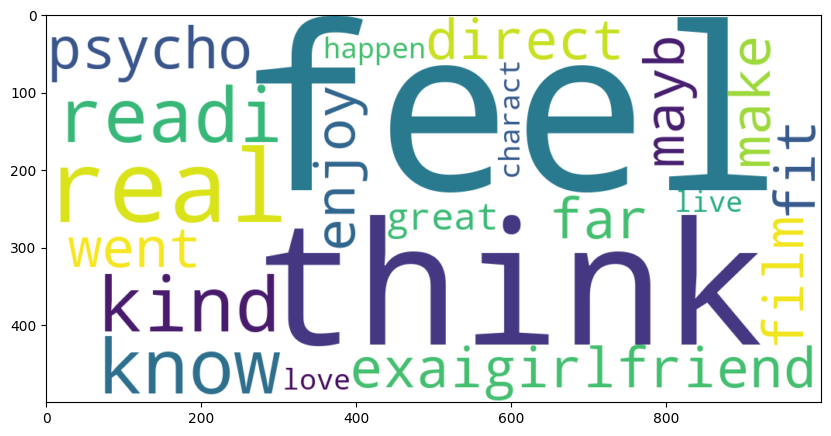

In [78]:
#Word cloud for negative comment words
plt.figure(figsize=(10,10))
negative_text=norm_train_comments[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=2,background_color="white")
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show